##### Copyright 2021 The TensorFlow Federated Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/federated/tutorials/federated_learning_with_differential_privacy"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/federated/blob/v0.52.0/docs/tutorials/federated_learning_with_differential_privacy.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/federated/blob/v0.52.0/docs/tutorials/federated_learning_with_differential_privacy.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/federated/docs/tutorials/federated_learning_with_differential_privacy.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Differential Privacy in TFF

This tutorial will demonstrate the recommended best practice for training models with user-level Differential Privacy using Tensorflow Federated. We will use the DP-SGD algorithm of [Abadi et al., "Deep Learning with Differential Privacy"](https://arxiv.org/abs/1607.00133) modified for user-level DP in a federated context in [McMahan et al., "Learning Differentially Private Recurrent Language Models"](https://arxiv.org/abs/1710.06963).

Differential Privacy (DP) is a widely used method for bounding and quantifying the privacy leakage of sensitive data when performing learning tasks. Training a model with user-level DP guarantees that the model is unlikely to learn anything significant about the data of any individual, but can still (hopefully!) learn patterns that exist in the data of many clients.

We will train a model on the federated EMNIST dataset. There is an inherent trade-off between utility and privacy, and it may be difficult to train a model with high privacy that performs as well as a state-of-the-art non-private model. For expediency in this tutorial, we will train for just 100 rounds, sacrificing some quality in order to demonstrate how to train with high privacy. If we used more training rounds, we could certainly have a somewhat higher-accuracy private model, but not as high as a model trained without DP.

## Before we begin

First, let us make sure the notebook is connected to a backend that has the relevant components compiled. 

In [2]:
# in Ubuntu 22.04 with conda 23.1.0, Python 3.9.16, and pip 23.0.1
# pip install --upgrade tensorflow-federated
# pip install --upgrade nest-asyncio
# conda install ipykernel
# python -m ipykernel install --user --name tff --display-name "Python (tff)"
# 

# (dp-accounting is not needed)

In [3]:
#@test {"skip": true}
# !pip install --quiet --upgrade dp-accounting
# !pip install --quiet --upgrade tensorflow-federated
# !pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

Some imports we will need for the tutorial. We will use `tensorflow_federated`, the open-source framework for machine learning and other computations on decentralized data, as well as `dp_accounting`, an open-source library for analyzing differentially private algorithms.

In [4]:
import collections

import dp_accounting
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff

2023-03-28 12:21:10.035331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 12:21:10.152014: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-28 12:21:10.152036: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-28 12:21:10.731310: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Run the following "Hello World"
example to make sure the TFF environment is correctly setup. If it doesn't work,
please refer to the [Installation](../install.md) guide for instructions.

In [5]:
@tff.federated_computation
def hello_world():
  return 'Hello, World!'

hello_world()

2023-03-28 12:21:11.950811: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-28 12:21:11.950838: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-28 12:21:11.950854: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-19-74): /proc/driver/nvidia/version does not exist
2023-03-28 12:21:11.950963: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 12:21:11.951167: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild 

b'Hello, World!'

## Download and preprocess the federated EMNIST dataset.

In [32]:
import math
import random
import tensorflow_addons as tfa

client_epochs_per_round = 2
only_digits = False

tf.random.set_seed(seed=1)

def get_emnist_dataset():
  emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(
      only_digits=only_digits)

  def rotation_fn(image):
    def rand_degree():
      upper = 5 * (math.pi / 180.0) # degrees -> radian
      lower = -5 * (math.pi / 180.0)
      return random.uniform(lower , upper)
        
    return tfa.image.rotate(image, rand_degree(), fill_value=1.0)

#   def crop_fn(image):
#     return tf.image.resize_with_crop_or_pad(
#         image, target_height=image.shape[0], target_width=image.shape[1])

  def normalize_fn(image):
    image = tf.cast(image, tf.float32) / 255.
    image = (image - 0.9637) / 0.1597
    return image

  def element_fn(element):
    return collections.OrderedDict(
#         x = tf.expand_dims(element['pixels'], -1),
        x=normalize_fn(
            rotation_fn(
                tf.expand_dims(element['pixels'], -1)
            )
        ),
        y=element['label']
    )

  def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
    return (dataset.map(element_fn)
                   .shuffle(buffer_size=418)
                   .repeat(count=client_epochs_per_round)
                   .batch(20, drop_remainder=False))
#                    .batch(32, drop_remainder=False))

  def preprocess_test_dataset(dataset):
    return dataset.map(element_fn).batch(128, drop_remainder=False)

  emnist_train = emnist_train.preprocess(preprocess_train_dataset)
  emnist_test = preprocess_test_dataset(
      emnist_test.create_tf_dataset_from_all_clients())

  return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

tf.Tensor(12, shape=(), dtype=int32) (28, 28, 1)


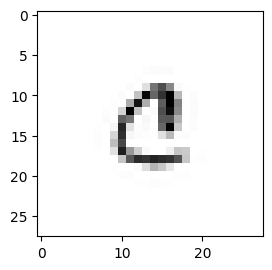

tf.Tensor(36, shape=(), dtype=int32) (28, 28, 1)


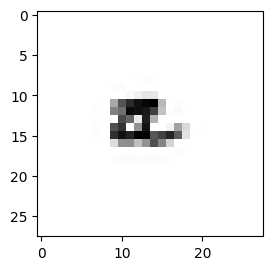

tf.Tensor(40, shape=(), dtype=int32) (28, 28, 1)


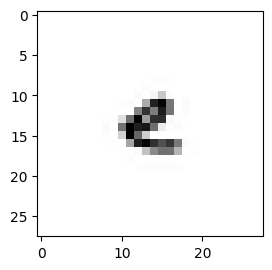

In [33]:
# import matplotlib.pyplot as plt

# first_client_id = train_data.client_ids[0]
# first_client_dataset = train_data.create_tf_dataset_for_client(first_client_id)
# it = iter(first_client_dataset)
# first_batch = next(it)

# for idx, image in enumerate(first_batch['x'][:3]):
#     plt.subplot(1,2,1) 
#     print(first_batch['y'][idx], image.shape)
#     plt.imshow(image, cmap='gray')
#     plt.show()

In [35]:
import tensorflow_datasets as tfds

virtual_client_cnt = 0
virtual_global_dataset = {}
physcial_clients_per_merge = 3

physical_client_cnt = 0
virtual_client_cnt = 0
temp_physical_dataset_list = []
# TODO: optimize with multiprocessing
for client_id in train_data.client_ids:
  physical_client_dataset = tfds.as_numpy(train_data.create_tf_dataset_for_client(client_id))
  temp_physical_dataset_list.append(physical_client_dataset._ds)

  if (physical_client_cnt + 1) % physcial_clients_per_merge == 0:
    virtual_client_dataset = temp_physical_dataset_list[0]

    for i in range(physcial_clients_per_merge - 1):
        j = i + 1
        virtual_client_dataset = virtual_client_dataset.concatenate(temp_physical_dataset_list[j])

    virtual_global_dataset.update({
        virtual_client_cnt: virtual_client_dataset
    })
    virtual_client_cnt += 1
    temp_physical_dataset_list = []
    if virtual_client_cnt == 1000:
        break

  physical_client_cnt += 1

print(physical_client_cnt + 1, virtual_client_cnt)

3000 1000


In [42]:
first_virtual_client_id = 0
first_virtual_client_dataset = virtual_global_dataset[first_virtual_client_id]
it = iter(first_virtual_client_dataset)

first_virtual_client_dataset_size_after_repetition = 0
for b in it:
  first_virtual_client_dataset_size_after_repetition += len(b['x'])
print(first_virtual_client_dataset_size_after_repetition)

2064


## Define our model.

In [43]:
seed = 1
data_format = 'channels_last'
initializer = tf.keras.initializers.GlorotUniform(seed=seed)

def my_model_fn():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(
          32,
          kernel_size=(3, 3),
          activation='relu',
          data_format=data_format,
          input_shape=(28, 28, 1),
          kernel_initializer=initializer),
      tf.keras.layers.MaxPool2D(pool_size=(2, 2), data_format=data_format),
      tf.keras.layers.Conv2D(
          64,
          kernel_size=(3, 3),
          activation='relu',
          data_format=data_format,
          kernel_initializer=initializer),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          128, activation='relu', kernel_initializer=initializer),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(
          10 if only_digits else 62,
          activation=tf.nn.softmax,
          kernel_initializer=initializer),
  ])
#       tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
#       tf.keras.layers.Dense(200, activation=tf.nn.relu),
#       tf.keras.layers.Dense(200, activation=tf.nn.relu),
#       tf.keras.layers.Dense(10)])
  return tff.learning.models.from_keras_model(
      keras_model=model,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      input_spec=test_data.element_spec,
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

## Determine the noise sensitivity of the model.

To get user-level DP guarantees, we must change the basic Federated Averaging algorithm in two ways. First, the clients' model updates must be clipped before transmission to the server, bounding the maximum influence of any one client. Second, the server must add enough noise to the sum of user updates before averaging to obscure the worst-case client influence.

For clipping, we use the adaptive clipping method of [Andrew et al. 2021, Differentially Private Learning with Adaptive Clipping](https://arxiv.org/abs/1905.03871), so no clipping norm needs to be explicitly set.

Adding noise will in general degrade the utility of the model, but we can control the amount of noise in the average update at each round with two knobs: the standard deviation of the Gaussian noise added to the sum, and the number of clients in the average. Our strategy will be to first determine how much noise the model can tolerate with a relatively small number of clients per round with acceptable loss to model utility. Then to train the final model, we can increase the amount of noise in the sum, while proportionally scaling up the number of clients per round (assuming the dataset is large enough to support that many clients per round). This is unlikely to significantly affect model quality, since the only effect is to decrease variance due to client sampling (indeed we will verify that it does not in our case).

To that end, we first train a series of models with 50 clients per round, with increasing amounts of noise. Specifically, we increase the "noise_multiplier" which is the ratio of the noise standard deviation to the clipping norm. Since we are using adaptive clipping, this means that the actual magnitude of the noise changes from round to round.

In [44]:
total_clients = virtual_client_cnt
# total_clients = len(train_data.client_ids)

clients_per_thread = 5
# clients_per_thread = 5
# tff.backends.native.set_sync_local_cpp_execution_context(
#     max_concurrent_computation_calls=total_clients / clients_per_thread)

def train(rounds, noise_multiplier, clients_per_round, data_frame):
  # Using the `dp_aggregator` here turns on differential privacy with adaptive
  # clipping.
  aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
      noise_multiplier, clients_per_round)

  # We use Poisson subsampling which gives slightly tighter privacy guarantees
  # compared to having a fixed number of clients per round. The actual number of
  # clients per round is stochastic with mean clients_per_round.
#   sampling_prob = clients_per_round / total_clients

  # Build a federated averaging process.
  # Typically a non-adaptive server optimizer is used because the noise in the
  # updates can cause the second moment accumulators to become very large
  # prematurely.
  learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
        my_model_fn,
#         client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01, momentum=0.9),
#         server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0),
        model_aggregator=aggregation_factory)

  eval_process = tff.learning.build_federated_evaluation(my_model_fn)
    
  # Training loop.
  state = learning_process.initialize()
  for round in range(rounds):
    print(f"Round {round}")
    if round % 1 == 0:
      model_weights = learning_process.get_model_weights(state)
      metrics = eval_process(model_weights, [test_data])['eval']
      if round % 1 == 0:
#       if round < 25 or round % 25 == 0:
        print(f'Round {round:3d}: {metrics}')
      data_frame = data_frame.append({'Round': round,
                                      'NoiseMultiplier': noise_multiplier,
                                      **metrics}, ignore_index=True)

    # Sample clients for a round. Note that if your dataset is large and
    # sampling_prob is small, it would be faster to use gap sampling.
    sampled_clients = np.random.choice(
        a=total_clients,
        size=clients_per_round,
        replace=False
    )
#     print(f"Sampled clients: {sampled_clients}")
#     x = np.random.uniform(size=total_clients)
#     sampled_clients = [
#         train_data.client_ids[i] for i in range(total_clients)
#         if x[i] < sampling_prob]
    
    sampled_train_data = [
        virtual_global_dataset[client] for client in sampled_clients
    ]
#     sampled_train_data = [
#         train_data.create_tf_dataset_for_client(client)
#         for client in sampled_clients]

    # Use selected clients for update.
    result = learning_process.next(state, sampled_train_data)
    state = result.state
    metrics = result.metrics

  model_weights = learning_process.get_model_weights(state)
  metrics = eval_process(model_weights, [test_data])['eval']
  print(f'Round {rounds:3d}: {metrics}')
  data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)

  return data_frame


In [47]:
data_frame = pd.DataFrame()
rounds = 10
# rounds = 50
clients_per_round = 1000
# rounds = 100
# clients_per_round = 50

for noise_multiplier in [0.0]:
# for noise_multiplier in [0.0, 0.5, 0.75, 1.0]:
  print(f'Starting training with noise multiplier: {noise_multiplier}')
  data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)
  print()

Starting training with noise multiplier: 0.0


/tmp/ipykernel_495098/2449149110.py:32: DeprecationWarning: `tff.learning.build_federated_evaluation` is deprecated, use `tff.learning.algorithms.build_fed_eval` instead.
  eval_process = tff.learning.build_federated_evaluation(my_model_fn)
2023-03-28 15:07:55.854018: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:55.877488: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:55.883384: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:55.890676: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:55.906590: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:55.930400: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:55.941268: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


Round 0


2023-03-28 15:07:56.195099: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:56.254442: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:56.261163: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:56.270210: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:07:56.282463: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session


Round   0: OrderedDict([('sparse_categorical_accuracy', 0.010763652), ('loss', 4.125886), ('num_examples', 77483), ('num_batches', 606)])


/tmp/ipykernel_495098/2449149110.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,
2023-03-28 15:08:01.696511: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:08:01.833760: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:08:01.840840: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:08:01.849533: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:08:01.861797: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:08:01.877817: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:08:01.888631: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-28 15:08:01.9

Round 1
Round   1: OrderedDict([('sparse_categorical_accuracy', 0.049856097), ('loss', 4.1186633), ('num_examples', 77483), ('num_batches', 606)])


/tmp/ipykernel_495098/2449149110.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


Round 2
Round   2: OrderedDict([('sparse_categorical_accuracy', 0.049856097), ('loss', 4.1077724), ('num_examples', 77483), ('num_batches', 606)])


/tmp/ipykernel_495098/2449149110.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_frame = data_frame.append({'Round': round,


KeyboardInterrupt: 

Now we can visualize the evaluation set accuracy and loss of those runs.

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
  plt.figure(figsize=(15, 5))

  dff = data_frame.rename(
      columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

  plt.subplot(121)
  sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
  plt.subplot(122)
  sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
make_plot(data_frame)

It appears that with 50 expected clients per round, this model can tolerate a noise multiplier of up to 0.5 without degrading model quality. A noise multiplier of 0.75 seems to cause a bit of model degradation, and 1.0 makes the model diverge.

There is typically a tradeoff between model quality and privacy. The higher noise we use, the more privacy we can get for the same amount of training time and number of clients. Conversely, with less noise, we may have a more accurate model, but we'll have to train with more clients per round to reach our target privacy level.

With the experiment above, we might decide that the small amount of model deterioration at 0.75 is acceptable in order to train the final model faster, but let's assume we want to match the performance of the 0.5 noise-multiplier model.

Now we can use dp_accounting functions to determine how many expected clients per round we would need to get acceptable privacy. Standard practice is to choose delta somewhat smaller than one over the number of records in the dataset. This dataset has 3383 total training users, so let's aim for (2, 1e-5)-DP.

We use `dp_accounting.calibrate_dp_mechanism` to search over the number of clients per round. The privacy accountant (`RdpAccountant`) we use to estimate privacy given a `dp_accounting.DpEvent` is based on [Wang et al. (2018)](https://arxiv.org/abs/1808.00087) and [Mironov et al. (2019)](https://arxiv.org/pdf/1908.10530.pdf).

In [ ]:
total_clients = 3383
noise_to_clients_ratio = 0.01
target_delta = 1e-5
target_eps = 2

# Initialize arguments to dp_accounting.calibrate_dp_mechanism.

# No-arg callable that returns a fresh accountant.
make_fresh_accountant = dp_accounting.rdp.RdpAccountant

# Create function that takes expected clients per round and returns a 
# dp_accounting.DpEvent representing the full training process.
def make_event_from_param(clients_per_round):
  q = clients_per_round / total_clients
  noise_multiplier = clients_per_round * noise_to_clients_ratio
  gaussian_event = dp_accounting.GaussianDpEvent(noise_multiplier)
  sampled_event = dp_accounting.PoissonSampledDpEvent(q, gaussian_event)
  composed_event = dp_accounting.SelfComposedDpEvent(sampled_event, rounds)
  return composed_event

# Create object representing the search range [1, 3383].
bracket_interval = dp_accounting.ExplicitBracketInterval(1, total_clients)

# Perform search for smallest clients_per_round achieving the target privacy.
clients_per_round = dp_accounting.calibrate_dp_mechanism(
    make_fresh_accountant, make_event_from_param, target_eps, target_delta,
    bracket_interval, discrete=True
)

noise_multiplier = clients_per_round * noise_to_clients_ratio
print(f'To get ({target_eps}, {target_delta})-DP, use {clients_per_round} '
      f'clients with noise multiplier {noise_multiplier}.')

Now we can train our final private model for release.


In [ ]:
rounds = 100
noise_multiplier = 1.2
clients_per_round = 120

data_frame = pd.DataFrame()
data_frame = train(rounds, noise_multiplier, clients_per_round, data_frame)

make_plot(data_frame)

As we can see, the final model has similar loss and accuracy to the model trained without noise, but this one satisfies (2, 1e-5)-DP.